<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

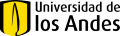

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Mini Proyecto 2, Técnicas de *Deep Learning*: Clasificación de Sentimientos de Reseñas de Películas en *IMDB* con Redes Neuronales Recurrentes**

## **Descripción del problema:**

En este proyecto abordamos el problema de clasificación de sentimiento en reseñas de películas. Partimos de un conjunto de datos extraído de Kaggle que contiene reseñas textuales (**`text`**) y una etiqueta binaria (**`label`**) que indica si la opinión es positiva (**1**) o negativa (**0**). El reto consiste en diseñar un modelo de *Deep Learning*, concretamente una Red Neuronal Recurrente con capas LSTM, capaz de procesar secuencias de texto y predecir con alta precisión la polaridad de cada reseña.

## **Objetivo:**

* Implementar un *pipeline* completo que incluya la descarga del dataset, el preprocesamiento de texto (tokenización, limpieza, construcción de vocabulario y padding de secuencias), y la definición de un Dataset y DataLoader en PyTorch.

* Diseñar una arquitectura basada en *embeddings* y una o varias capas LSTM (bidireccionales), con regularización por *dropout* y optimización con **`Adam`**.

* Entrenar el modelo utilizando GPU cuando esté disponible, incorporando técnicas de *early stopping* y gradient clipping para evitar sobreajuste y explosión de gradientes.

* Evaluar su desempeño final sobre el conjunto de prueba, calculando *accuracy*, *F1‑score*, *recall* y presentando la matriz de confusión.

* Visualizar la evolución de la pérdida y la exactitud en entrenamiento y validación a lo largo de las épocas.

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 9 de mayo.**


***
# Tareas

* Exploración y pre-procesamiento (Jordan)

* Introducción, y explicación de las opciones tomadas en el PDF (Andrés y Jordan)

* Comentarios en código, explicaciones en markdowns (Andrés y Jordan)

* Nube de Palabras (Jordan)

* Validación de idiomas Jorda)

* Glove  (Jordan)

* Word2vec (Andrés)

* LSTM o GRU  (Andrés)

* Mejorar red (Andrés)

* Pensar en ideas visualización (Andrés y Jordan)
- t-SNE

* Entrenamiento y evaluación de modelo (Andrés)

* Informe: Arquitectura, entrenamiento, evaluación, análisis cuantitativo (Andrés)

* Informe: Exploración, pre-procesamiento, análisis cualitativo, discusión (Jordan)




***
# **Índice**

El *notebook* abordará el proyecto de la siguiente manera:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣ | **Instalación y carga de librerías** |
| 2️⃣ | **Análisis exploratorio y preparación de los datos**       |
| 3️⃣ | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣ | **Pipeline de preprocesamiento ...**   |
| 4️⃣ | **Desarrollo del modelo RNN...**   |
| 4️⃣.1️⃣ | **Hiperparámetros, partición y Dataloaders**   |
| 4️⃣.2️⃣ | **Adaptación a partir de la arquitectura ...*   |
| 4️⃣.3️⃣ | **Entrenamiento, validación y prueba**   |
| 5️⃣ | **Análisis de resultados y conclusiones**   |
| 6️⃣ | **Referencias**   |



***

# 1. Instalación y cargue de librerías

Empezamos por el cargue de las librerias que se usarán para efectos de este proyecto. Estas incluyen:

* Librerías comunes para la lectura, procesamiento y ploteo básico de las imágenes.
* **`kagglehub`**, para poder descargar el dataset del miniproyecto de forma conveniente
* **`pytorch`** (de acuerdo, a la sugerencia del enunciado del proyecto) ....

In [ ]:
pip install kagglehub # Necesario para ejecutarse en Coursera

In [ ]:
# Librerías comunes
import os
import random
import time
import numpy as np
import pandas as pd
import time

# Preprocesamiento
from collections import Counter

# Librerías NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords') # "palabras vacías"

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

# Evaluación
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from tqdm import tqdm


# Librerías para visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Descarga del dataset
import kagglehub
path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")
print("Datos descargados en:", path)

Datos descargados en: /kaggle/input/imdb-movie-ratings-sentiment-analysis


In [ ]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Entrenando en GPU.")
else:
    print("GPU no disponible, entrenando en CPU.")

# 2) Elegir device según disponibilidad
device = torch.device("cuda" if train_on_gpu else "cpu")
print(f"   Usando device: {device}\n")

Entrenando en GPU.
   Usando device: cuda



In [ ]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ['numpy', 'pandas', 'torch', 'torchvision', 'scikit-learn', 'kagglehub', 'pillow','matplotlib','seaborn']
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
torchvision :  0.21.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
pillow :  11.2.1
matplotlib :  3.10.0
seaborn :  0.13.2


El siguiente bloque de código nos permite hacer determininísticas las funciones traídas de **`pytorch`**, y en general controlar todos los pseudo-aleatorios del *notebook*

In [ ]:
# Definición del random state y seeds
RANDOM_STATE = 13
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [ ]:
# Descargar el conjunto de datos y almacenar el path en una variable
data_raw = pd.read_csv(os.path.join(path, 'movie.csv'))
data_raw.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
label2index = {'Negativa':0, 'Positiva':1}
index2label = {0:'Negativa', 1:'Positiva'}

In [ ]:
# Frecuencias absoluta y relativa de cada clase
pd.DataFrame({
    "Review": index2label,
    "F. Absoluta": data_raw['label'].value_counts().sort_index(),
    "F. Relativa": data_raw['label'].value_counts(normalize=True).sort_index(),
})

,Review,F. Absoluta,F. Relativa
0,Negativa,20019,0.500475
1,Positiva,19981,0.499525


***

## 2.2. Limpieza de los datos

In [ ]:
data_raw.isna().sum()

,0
text,0
label,0


In [ ]:
data_raw.duplicated().sum()

np.int64(277)

In [ ]:
data = data_raw.drop_duplicates(keep='first')

# Frecuencias absoluta y relativa de cada clase
pd.DataFrame({
    "Review": index2label,
    "F. Absoluta": data['label'].value_counts().sort_index(),
    "F. Relativa": data['label'].value_counts(normalize=True).sort_index(),
})

,Review,F. Absoluta,F. Relativa
0,Negativa,19815,0.498829
1,Positiva,19908,0.501171


xxxxxx

Idiomas xxxx

In [ ]:
# #Identifica el Idioma de cada fila
# def identificar_idioma(X: pd.DataFrame):
#     X["idioma"] = X['textos'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else "desconocido")
#     return X

# X_deteccion = identificar_idioma(data)
# print(X_deteccion['idioma'].value_counts())

In [ ]:
# indices_a_traducir = data[data['idioma'] != 'es'].index
# translator = Translator()

# # Traducción hecha con google translate
# def traducir_texto_fila(fila):
#     texto = fila['textos']
#     idioma_original = fila['idioma']
#     if isinstance(texto, str) and texto.strip():
#         return translator.translate(texto, src=idioma_original, dest="es").text
#     return texto

# # Aplicando la traducción
# data.loc[indices_a_traducir, 'textos'] = data.loc[indices_a_traducir].apply(traducir_texto_fila, axis=1)

# # Ahora los textos han sido traducios al español
# for texto in data.loc[indices_a_traducir, 'textos']:
#     print(texto, "\n")

In [ ]:
# nltk_stopwords_set = set(stopwords.words("spanish"))

In [ ]:
# def preprocesamiento_exploratorio(X: pd.DataFrame):
#     # Tokenizar a nivel de palabra y pasar a minúsculas
#     tokenizer = RegexpTokenizer(r"\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ'-]+")

#     X_preprocesado = X.apply(lambda x: tokenizer.tokenize(x))
#     X_preprocesado = [[t.lower() for t in text] for text in X_preprocesado]

#     # Filtrar palabras vacías
#     X_preprocesado = [[token for token in text if token not in nltk_stopwords_set] for text in X_preprocesado]
#     texto_nube = ' '.join(word for text in X_preprocesado for word in text)
#     return texto_nube

In [ ]:
# #Visualización inicial de las palabras que contienen los documentos.
# texto_nube = preprocesamiento_exploratorio(X_train['textos'])

# # Generación Nube de Palabras
# wordcloud = WordCloud(
#     width=800,
#     height=400,
#     background_color ='white',
#     min_font_size=10,
#     max_font_size=110,
#     max_words=100
# ).generate(texto_nube)
# plt.figure(figsize=(10, 10))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

In [ ]:
# #Conversión a dataframe
# def palabras_a_dataframe(texto):
#     palabras = texto.split()  # Dividir el texto en palabras por espacios
#     conteo = Counter(palabras)  # Contar ocurrencias de cada palabra
#     df = pd.DataFrame(conteo.items(), columns=['Palabra', 'Frecuencia'])
#     df = df.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)  # Ordenar y resetear índice
#     return df

# conteo_palabras = palabras_a_dataframe(texto_nube)
# conteo_top = conteo_palabras.head(20)

# # Top 20 palabras
# plt.figure(figsize=(5, 5))
# sns.barplot(x=conteo_top["Frecuencia"], y=conteo_top["Palabra"], palette="viridis")
# plt.xlabel("Frecuencia")
# plt.ylabel("Palabra")
# plt.title(f"Top {20} Palabras más Frecuentes")
# plt.show()

In [ ]:
# counts = data['ODS'].value_counts()
# counts_train = y_train.value_counts()

# # Gráfica de la proporcionalidad de las clases y los conjuntos divididos
# fig, ax = plt.subplots(1, 1, figsize=(5,5))
# ax.barh(range(0,16), counts, label="Test")
# ax.barh(range(0,16), counts_train, label="Train")
# ax.set_yticks(range(0,16), labels=[ods[l-1] + f" ({l})" for l in counts.index])
# ax.invert_yaxis()
# plt.title("Distribución del split estratificado")
# plt.legend()
# fig.show()

El objetivo de esta sección es incorporar varios estilos de pre-procesamiento, probar diferentes maneras de depurar los textos como por ejemplo remover caracteres no alfanuméricos, a excepción de guiones o apóstrofes. También haremos uso de dos normalizadores: *Stemming* y *Lemmatization*, ....

***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

...

Inspiración ... [¹]

In [ ]:
english_stop = set(stopwords.words('english'))

def clean_and_tokenize(text):
    # extrae solo palabras alfabéticas
    tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    return [t for t in tokens if t not in english_stop]

# Prueba
example = data.loc[0, 'text']
print(clean_and_tokenize(example))

['grew', 'b', 'watching', 'loving', 'thunderbirds', 'mates', 'school', 'watched', 'played', 'thunderbirds', 'school', 'lunch', 'school', 'wanted', 'virgil', 'scott', 'one', 'wanted', 'alan', 'counting', 'became', 'art', 'form', 'took', 'children', 'see', 'movie', 'hoping', 'would', 'get', 'glimpse', 'loved', 'child', 'bitterly', 'disappointing', 'high', 'point', 'snappy', 'theme', 'tune', 'could', 'compare', 'original', 'score', 'thunderbirds', 'thankfully', 'early', 'saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'series', 'gerry', 'anderson', 'wife', 'created', 'jonatha', 'frakes', 'hand', 'directors', 'chair', 'version', 'completely', 'hopeless', 'waste', 'film', 'utter', 'rubbish', 'cgi', 'remake', 'may', 'acceptable', 'replacing', 'marionettes', 'homo', 'sapiens', 'subsp', 'sapiens', 'huge', 'error', 'judgment']


In [ ]:
all_tokens = [tok for txt in data['text'] for tok in clean_and_tokenize(txt)]
freq = Counter(all_tokens)

# Top‑20 000 + <PAD>=0, <UNK>=1
vocab = {w:i+2 for i,(w,_) in enumerate(freq.most_common(20000))}
#Indicadores de inicio y final
vocab.update({'<PAD>':0,'<UNK>':1})

def encode(tokens, max_len=200):
    seq = [vocab.get(t,1) for t in tokens]
    # Completa secuencia hasta tener max_len
    return seq[:max_len] + [0]*(max_len-len(seq))

***

# 4. Desarrollo del modelo RNN....

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

Informa que la construcción del modelo es basado en ...[²]

Se usa una partición **80/10/10** para los datos de entrenamiento, validación y *test*, respectivamente. También se define **`device`** que nos permitirá ir alternado el uso de GPU y de CPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, df, max_len=200):
        self.texts  = df['text'].tolist()
        self.labels = df['label'].astype(int).tolist()
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        toks = clean_and_tokenize(self.texts[i])
        return torch.tensor(encode(toks,self.max_len)), torch.tensor(self.labels[i],dtype=torch.float)

# Split 80/10/10 con semilla fija
ds = IMDBDataset(data)
n = len(ds)
train_ds, val_ds, test_ds = random_split(ds, [int(.8*n),int(.1*n),n-int(.9*n)], generator=torch.Generator().manual_seed(RANDOM_STATE))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size, shuffle=False)

Aquí según lo que he leído se puede entrenar la capa de embedding con Word2Vec, revisar...

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hid_dim=128, n_layers=2, bidir=True, drop=0.5):
        super().__init__()
        # Capa de embedding
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        # RNN
        self.lstm      = nn.LSTM(emb_dim, hid_dim, n_layers, bidirectional=bidir, batch_first=True, dropout=drop)
        # Droput
        self.dropout   = nn.Dropout(drop)
        # Red completamente conectada
        self.fc        = nn.Linear(hid_dim*(2 if bidir else 1), 1)
    def forward(self, x):
        emb, _ = self.embedding(x), None
        out, _ = self.lstm(emb)
        h_last = out[:, -1, :]
        return torch.sigmoid(self.fc(self.dropout(h_last))).squeeze()

***

## 4.3. Entrenamiento, validación y prueba

xxxxxx


In [ ]:
lr=0.001
epochs = 10

model     = SentimentRNN(len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)
#Gradient Clipping
clip      = 5
best_val = float('inf'); epochs_no_imp=0; patience=3


history = {
    'train_loss': [], 'val_loss': [],
    'train_acc' : [], 'val_acc' : []
}


start_time = time.time()
for epoch in range(1, epochs+1):
    # ——— Entrenamiento ———
    model.train()
    running_loss = 0
    running_corrects = 0
    total_train = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # Acumula loss
        running_loss += loss.item() * x.size(0)
        # Acumula accuracy
        preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds == y).item()
        total_train     += x.size(0)

    epoch_train_loss = running_loss / total_train
    epoch_train_acc  = running_corrects / total_train

    # ——— Validación ———
    model.eval()
    val_loss = 0
    val_corrects = 0
    total_val = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            val_loss += criterion(outputs, y).item() * x.size(0)

            preds = (outputs >= 0.5).float()
            val_corrects += torch.sum(preds == y).item()
            total_val     += x.size(0)

    epoch_val_loss = val_loss / total_val
    epoch_val_acc  = val_corrects / total_val

    # ——— Guardar en history ———
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'  ].append(epoch_val_loss)
    history['train_acc' ].append(epoch_train_acc)
    history['val_acc'   ].append(epoch_val_acc)

    print(f"Epoch {epoch:02d}  "
          f"Train Loss: {epoch_train_loss:.4f}  Train Acc: {epoch_train_acc:.4f}  "
          f"Val Loss:   {epoch_val_loss:.4f}  Val Acc:   {epoch_val_acc:.4f}")

    # Early stopping (igual que antes)…
    if epoch_val_loss < best_val:
        best_val = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_imp = 0
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print("→ Early stopping")
            break

elapsed = time.time() - start_time
mins, secs = divmod(elapsed, 60)
print(f"\n Tiempo total de entrenamiento: {int(mins)} min {int(secs)} seg ({elapsed:.1f} seg)")

Epoch 01  Train Loss: 0.6931  Train Acc: 0.5094  Val Loss:   0.6914  Val Acc:   0.5218
Epoch 02  Train Loss: 0.6889  Train Acc: 0.5209  Val Loss:   0.6876  Val Acc:   0.5200
Epoch 03  Train Loss: 0.6620  Train Acc: 0.5992  Val Loss:   0.6290  Val Acc:   0.6705
Epoch 04  Train Loss: 0.6266  Train Acc: 0.6552  Val Loss:   0.6333  Val Acc:   0.6760
Epoch 05  Train Loss: 0.5956  Train Acc: 0.6923  Val Loss:   0.6098  Val Acc:   0.6873
Epoch 06  Train Loss: 0.5422  Train Acc: 0.7353  Val Loss:   0.5244  Val Acc:   0.7392
Epoch 07  Train Loss: 0.3761  Train Acc: 0.8406  Val Loss:   0.3770  Val Acc:   0.8357
Epoch 08  Train Loss: 0.2629  Train Acc: 0.8978  Val Loss:   0.3589  Val Acc:   0.8568
Epoch 09  Train Loss: 0.2072  Train Acc: 0.9262  Val Loss:   0.3737  Val Acc:   0.8655
Epoch 10  Train Loss: 0.1608  Train Acc: 0.9467  Val Loss:   0.3761  Val Acc:   0.8632


***


# 5. Análisis de resultados y conclusiones

xxxxx calculando *Accuracy*, *Recall*, *F1-macro* y la *Matriz de confusión*xxxx

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Pérdidas
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Exactitudes
    plt.figure(figsize=(8,4))
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

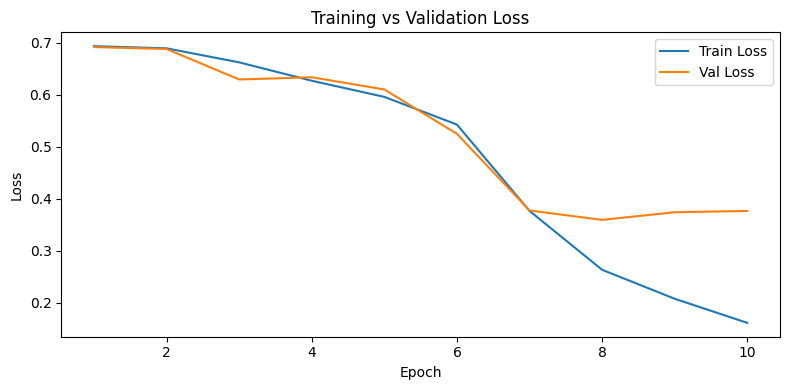

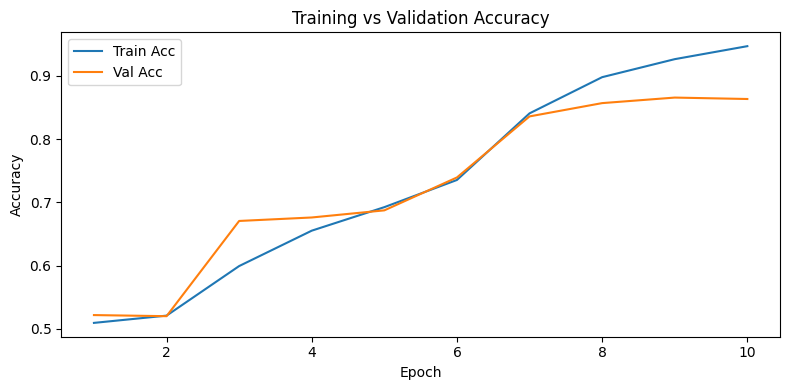

In [ ]:
plot_history(history)

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x,y in test_loader:
        out = (model(x.to(device)).cpu().numpy() >= 0.5).astype(int)
        y_pred.extend(out.tolist())
        y_true.extend(y.numpy().astype(int).tolist())

print("Accuracy:", accuracy_score(y_true,y_pred))
print("Recall:", recall_score(y_true,y_pred))
print("F1‑score:", f1_score(y_true,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true,y_pred))

Accuracy: 0.8585
Recall: 0.8492338111715274
F1‑score: 0.8585707146426786
Confusion Matrix:
 [[1716  261]
 [ 305 1718]]


In [ ]:
def predict_sentiment(review_text: str,
                      model: nn.Module,
                      vocab: dict,
                      sequence_length: int = 200,
                      device: torch.device = device) -> None:
    """
    Usa el modelo entrenado para predecir si `review_text` es positiva o negativa.
    - review_text: cadena con la reseña a clasificar.
    - model: instancia de SentimentRNN ya entrenada.
    - vocab: diccionario palabra->índice.
    - sequence_length: longitud fija del input (padding/truncado).
    - device: 'cuda' o 'cpu'.
    """
    model.eval()

    # 1) Tokenizar y limpiar
    tokens = clean_and_tokenize(review_text)

    # 2) Codificar + pad/truncado
    idxs = [vocab.get(t, vocab['<UNK>']) for t in tokens]
    if len(idxs) < sequence_length:
        idxs += [vocab['<PAD>']] * (sequence_length - len(idxs))
    else:
        idxs = idxs[:sequence_length]

    # 3) Tensor batch_size=1 y mover a device
    x = torch.tensor([idxs], dtype=torch.long).to(device)

    # 4) Forward sin gradientes
    with torch.no_grad():
        prob = model(x).item()  # valor [0,1]

    # 5) Mostrar resultados
    print(f"➡️  Score de positividad: {prob:.4f}")
    if prob >= 0.5:
        print("🟢  Positive review detected!")
    else:
        print("🔴  Negative review detected!")


In [ ]:
review = "Thanks to this movie we are all dumber than before."
predict_sentiment(review, model, vocab)

➡️  Score de positividad: 0.7303
🟢  Positive review detected!


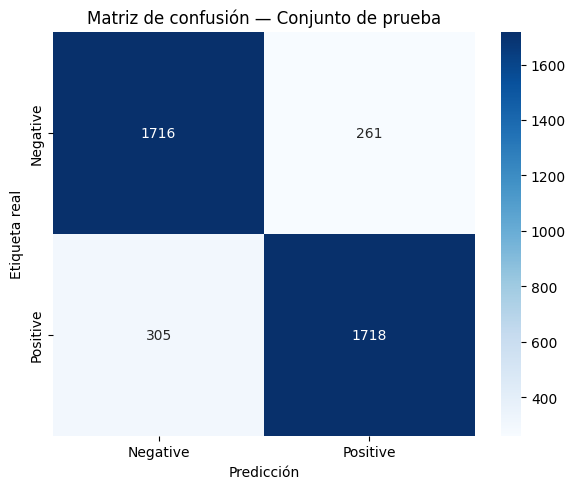

In [ ]:
cm      = confusion_matrix(y_true, y_pred)
class_names = ['Negative', 'Positive']
plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión — Conjunto de prueba")
plt.tight_layout()
plt.show()


Teniendo en cuenta el análisis anterior se procede a generar algunos ejemplos de las clasificación obtenida a partir del modelo CNN entrenado

***


# 6. Referencias


[¹] **Pytorch, Sentiment Analysis**  
Disponible en: [github.com](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb)

[²] **Sentiment Analysis with an RNN**  
Disponible en: [github.com](https://colab.research.google.com/github/agungsantoso/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Exercise.ipynb#scrollTo=TJHNs4FZpmwj)


